# Codeword Length = 15, T = 5, p(BSC parameter) {0.01, 0.05, 0.1, 0.2}

In [1]:
# changepoint_detection_updated.py
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
print(os.listdir("/kaggle/input/bsc-0-01-15-seq-len"))

['bsc_p0.40_codewords1.csv', 'bsc_p0.20_codewords2.csv', 'bsc_p0.01_codewords1.csv', 'bsc_p0.05_codewords1.csv', 'bsc_p0.01_codewords2.csv', 'bsc_p0.30_codewords1.csv', 'bsc_p0.10_codewords1.csv', 'bsc_p0.20_codewords1.csv', 'bsc_p0.10_codewords2.csv', 'bsc_p0.30_codewords2.csv', 'bsc_p0.40_codewords2.csv', 'bsc_p0.05_codewords2.csv']


Step-by-Step Summary: Changepoint Detection Pipeline
1. Configuration Setup
Sets training parameters: sequence length T, number of classes T+1, batch size, learning rate, etc.
Specifies number of samples per class for training, validation, and testing.

2. Seeding
Fixes random seeds for reproducibility using torch, numpy, and random.

3. Load Raw Codeword Data
Reads two .csv files: one for codewords from Code1, another for Code2.
Each row represents a codeword vector of fixed length.

4. Dataset Generation
Uses generate_data_cpd() to synthesize labeled examples:
Class 0: all codewords from Code1
Class T: all codewords from Code2
Classes 1–(T−1): changepoint at position τ, mixing Code1 and Code2

Creates separate datasets:
Train: SAMPLES_PER_CLASS_TRAIN × (T+1)
Validation and Test: SAMPLES_PER_CLASS_TEST × (T+1) each

5. Label Distribution Plot
Visualizes training class distribution to confirm balanced dataset.

6. Dataset Wrapping & Loading
Wraps data in a ChangepointDataset class using PyTorch Dataset.
Loads data into DataLoader for efficient batching.

7. Model Definition
Defines a CNN-based model:
MultiscaleFeatureExtractor: 1D convs with different kernel sizes
ResidualBlock1D: ResNet-style skip connections
Classifier: global average pooling → linear classifier
Model predicts one of T+1 classes for each segment.

8. Training Loop
Trains using CrossEntropyLoss and Adam optimizer.
Monitors validation accuracy, uses:
ReduceLROnPlateau scheduler
Early stopping after PATIENCE epochs without improvement
Keeps best model checkpoint based on validation accuracy.

9. Evaluation
Loads best model.
Evaluates on test set and prints strict classification accuracy.

10. Relaxed Accuracy
Computes relaxed accuracy: prediction is correct if within ±window of true class.

Plots relaxed accuracy vs. window size.

11. Final Visualization : 
Loss and accuracy curves during training
Relaxed accuracy plot
Confusion matrix heatmap of test predictions
This pipeline trains a robust sequence classifier to detect changepoints between two codeword sources.



### How this will be used in the pipeline

### **Changepoint Detection Summary**

- **Model Input**: Sliding window of size `T`
- **Model Output**: Class label `τ̂ ∈ [0, T]`
  - `τ̂ = 0`: all from Code1
  - `τ̂ = T`: all from Code2
  - `τ̂ ∈ [1, T−1]`: changepoint at index `τ̂` in window

---

### **Changepoint Index Formula**


- `i`: start index of the window  
- `τ̂`: predicted class by the model  

This gives the **index of the first Code2 element**.

---

### **Example**

- Let `T = 5`, window starts at `i = 8`, and prediction = `τ̂ = 2`  
→ **Changepoint = 8 + 2 = 10**


### Goal: Detect the Changepoint in a Long Sequence Using a Trained Model

---

### What This Code Will Do (Step-by-Step)

1. **Input** a long sequence of codewords (from `Code1` followed by `Code2`, with a single changepoint).
2. **Slide a window** of size `T` over the sequence (stride = 1).
3. **Use your trained model** to classify each window into one of `T + 1` classes:
   - `0`: all codewords from Code1
   - `T`: all codewords from Code2
   - `1 ≤ τ̂ ≤ T-1`: changepoint is at position `τ̂` within the window
4. **Estimate the changepoint position** using:


- `i` is the start index of the window
- `τ̂` is the predicted class
5. **Return the first detected changepoint**, or continue through the sequence to refine it.

---

### Key Notes

- Uses your **already trained model** — no retraining required.
- Works on any **long sequence** with a single changepoint.
- Common and effective approach for inference with sequence classifiers.

---

### Code: Sliding Window Changepoint Detection

```python
def detect_changepoint_in_sequence(long_sequence, model, T, device):
 model.eval()
 preds = []
 changepoint_idx = None

 for i in range(len(long_sequence) - T + 1):
     window = long_sequence[i:i + T]  # (T, feature_size)
     input_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)

     with torch.no_grad():
         output = model(input_tensor)
         pred_class = output.argmax(dim=1).item()
         preds.append(pred_class)

     if 1 <= pred_class <= T - 1 and changepoint_idx is None:
         changepoint_idx = i + pred_class

 return changepoint_idx, preds


changepoint, pred_labels = detect_changepoint_in_sequence(long_sequence, model, T, device)
print("Detected changepoint index:", changepoint)


## p = 0.01

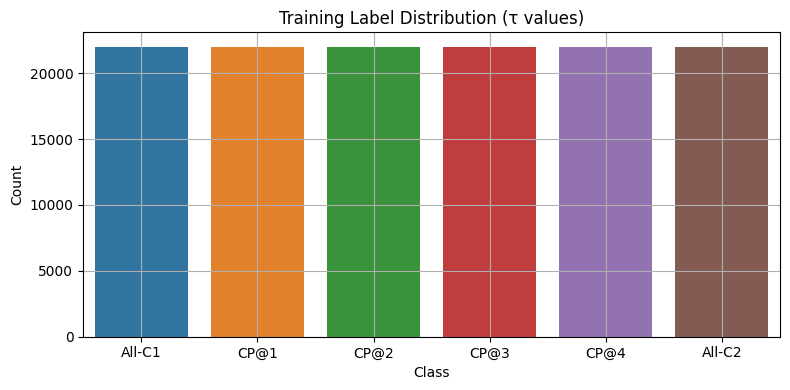

Training Epochs:   2%|▏         | 1/50 [00:11<09:36, 11.77s/it]

Epoch  1 | Train Loss: 1.7953 | Val Accuracy: 0.1842


Training Epochs:   4%|▍         | 2/50 [00:23<09:24, 11.77s/it]

Epoch  2 | Train Loss: 1.7847 | Val Accuracy: 0.2499


Training Epochs:   6%|▌         | 3/50 [00:35<09:19, 11.89s/it]

Epoch  3 | Train Loss: 1.3744 | Val Accuracy: 0.5466


Training Epochs:   8%|▊         | 4/50 [00:47<09:06, 11.88s/it]

Epoch  4 | Train Loss: 1.0198 | Val Accuracy: 0.6770


Training Epochs:  10%|█         | 5/50 [00:59<08:56, 11.93s/it]

Epoch  5 | Train Loss: 0.8489 | Val Accuracy: 0.7565


Training Epochs:  12%|█▏        | 6/50 [01:11<08:45, 11.95s/it]

Epoch  6 | Train Loss: 0.7258 | Val Accuracy: 0.8123


Training Epochs:  14%|█▍        | 7/50 [01:23<08:28, 11.83s/it]

Epoch  7 | Train Loss: 0.6230 | Val Accuracy: 0.8474


Training Epochs:  16%|█▌        | 8/50 [01:35<08:19, 11.89s/it]

Epoch  8 | Train Loss: 0.5313 | Val Accuracy: 0.8716


Training Epochs:  18%|█▊        | 9/50 [01:46<08:06, 11.87s/it]

Epoch  9 | Train Loss: 0.4586 | Val Accuracy: 0.8940


Training Epochs:  20%|██        | 10/50 [01:58<07:54, 11.87s/it]

Epoch 10 | Train Loss: 0.3996 | Val Accuracy: 0.9089


Training Epochs:  22%|██▏       | 11/50 [02:10<07:44, 11.91s/it]

Epoch 11 | Train Loss: 0.3503 | Val Accuracy: 0.9225


Training Epochs:  24%|██▍       | 12/50 [02:22<07:31, 11.88s/it]

Epoch 12 | Train Loss: 0.3082 | Val Accuracy: 0.9315


Training Epochs:  26%|██▌       | 13/50 [02:34<07:16, 11.80s/it]

Epoch 13 | Train Loss: 0.2781 | Val Accuracy: 0.9371


Training Epochs:  28%|██▊       | 14/50 [02:46<07:06, 11.86s/it]

Epoch 14 | Train Loss: 0.2522 | Val Accuracy: 0.9439


Training Epochs:  30%|███       | 15/50 [02:58<06:55, 11.87s/it]

Epoch 15 | Train Loss: 0.2314 | Val Accuracy: 0.9498


Training Epochs:  32%|███▏      | 16/50 [03:10<06:45, 11.92s/it]

Epoch 16 | Train Loss: 0.2131 | Val Accuracy: 0.9534


Training Epochs:  34%|███▍      | 17/50 [03:21<06:30, 11.84s/it]

Epoch 17 | Train Loss: 0.2003 | Val Accuracy: 0.9579


Training Epochs:  36%|███▌      | 18/50 [03:33<06:19, 11.85s/it]

Epoch 18 | Train Loss: 0.1909 | Val Accuracy: 0.9592


Training Epochs:  38%|███▊      | 19/50 [03:45<06:07, 11.86s/it]

Epoch 19 | Train Loss: 0.1817 | Val Accuracy: 0.9610


Training Epochs:  40%|████      | 20/50 [03:57<05:57, 11.93s/it]

Epoch 20 | Train Loss: 0.1717 | Val Accuracy: 0.9631


Training Epochs:  42%|████▏     | 21/50 [04:09<05:46, 11.93s/it]

Epoch 21 | Train Loss: 0.1647 | Val Accuracy: 0.9652


Training Epochs:  44%|████▍     | 22/50 [04:21<05:32, 11.88s/it]

Epoch 22 | Train Loss: 0.1579 | Val Accuracy: 0.9654


Training Epochs:  46%|████▌     | 23/50 [04:33<05:21, 11.92s/it]

Epoch 23 | Train Loss: 0.1537 | Val Accuracy: 0.9664


Training Epochs:  48%|████▊     | 24/50 [04:45<05:10, 11.94s/it]

Epoch 24 | Train Loss: 0.1476 | Val Accuracy: 0.9649


Training Epochs:  50%|█████     | 25/50 [04:57<04:57, 11.92s/it]

Epoch 25 | Train Loss: 0.1426 | Val Accuracy: 0.9685


Training Epochs:  52%|█████▏    | 26/50 [05:09<04:46, 11.95s/it]

Epoch 26 | Train Loss: 0.1398 | Val Accuracy: 0.9667


Training Epochs:  54%|█████▍    | 27/50 [05:21<04:34, 11.93s/it]

Epoch 27 | Train Loss: 0.1368 | Val Accuracy: 0.9686


Training Epochs:  56%|█████▌    | 28/50 [05:32<04:22, 11.91s/it]

Epoch 28 | Train Loss: 0.1341 | Val Accuracy: 0.9684


Training Epochs:  56%|█████▌    | 28/50 [05:44<04:30, 12.31s/it]

Epoch 29 | Train Loss: 0.1295 | Val Accuracy: 0.9697
Early stopping triggered.



Final Test Accuracy: 0.9689



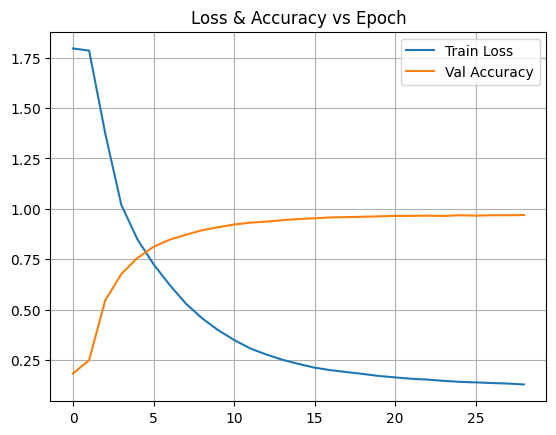

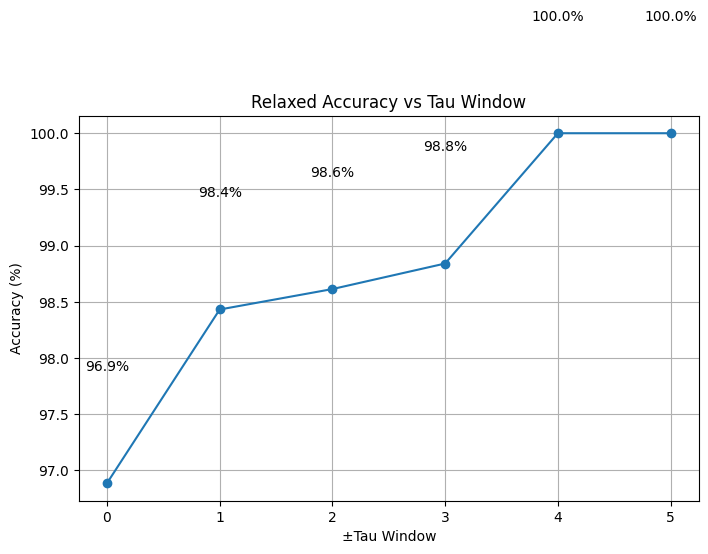

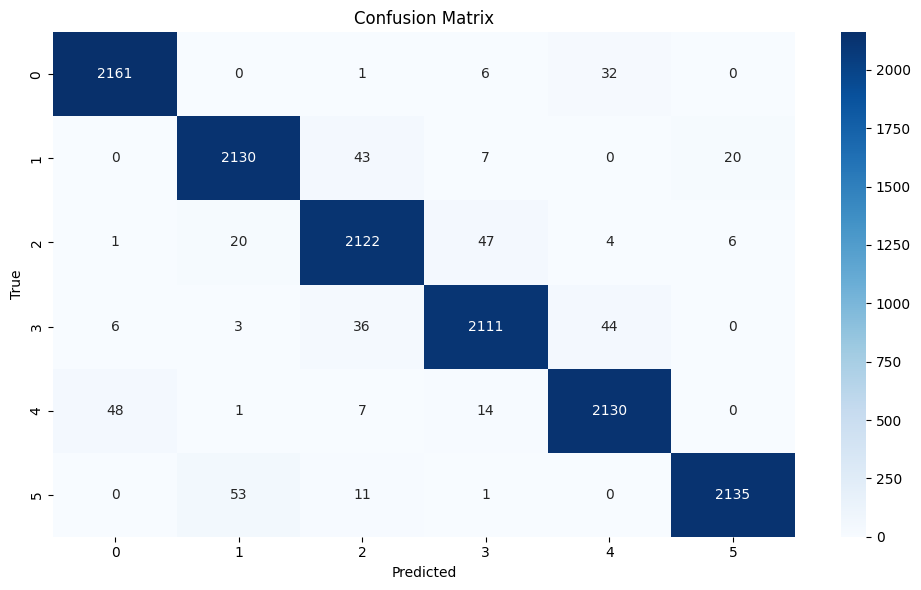

In [4]:
# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 22000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.01_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.01_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 5, p = 0.01, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 15.5, 42.2, 64.2, 83.0, 96.5, 100.0
For N'(training samples/class) = 2000     Accuracy = 18.3, 45.3, 66.0, 82.2, 94.2, 100.0
For N'(training samples/class) = 3000     Accuracy = 17.4, 46.0, 69.2, 84.9, 95.2, 100.0
For N'(training samples/class) = 4000     Accuracy = 83.5, 91.8, 92.7, 93.5, 100.0, 100.0
For N'(training samples/class) = 5000     Accuracy = 87.3, 94.1, 94.5, 95.1, 100.0, 100.0
For N'(training samples/class) = 6000     Accuracy = 89.3, 94.4, 95.0, 95.7, 100.0, 100.0
For N'(training samples/class) = 8000     Accuracy = 94.4, 97.0, 97.3, 97.6, 100.0, 100.0
For N'(training samples/class) = 10000     Accuracy = 95.2, 97.3, 97.7, 98.0, 100.0, 100.0
For N'(training samples/class) = 11000     Accuracy = 96.0, 97.9, 98.1, 98.3, 100.0, 100.0
For N'(training samples/class) = 15000     Accuracy = 96.4, 98.1, 98.4, 98.6, 100.0, 100.0
For N'(training samples/class) = 17000     Accuracy = 96.1, 98.0, 98.2, 98.4, 100.0, 100.0
For N'(training samples/class) = 20000     Accuracy = 96.9, 98.4, 98.6, 98.8, 100.0, 100
</pre>

In [ ]:
print("Predicted labels (test set):", all_preds.tolist())


## p = 0.05

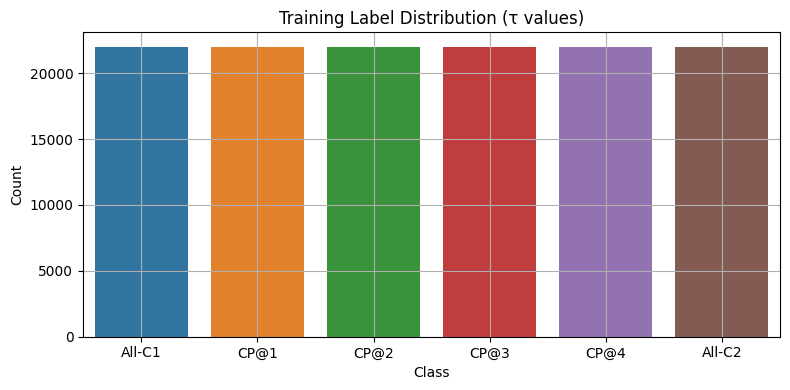

Training Epochs:   2%|▏         | 1/50 [00:12<10:21, 12.69s/it]

Epoch  1 | Train Loss: 1.7959 | Val Accuracy: 0.1705


Training Epochs:   4%|▍         | 2/50 [00:25<10:09, 12.69s/it]

Epoch  2 | Train Loss: 1.7907 | Val Accuracy: 0.1830


Training Epochs:   6%|▌         | 3/50 [00:38<09:59, 12.75s/it]

Epoch  3 | Train Loss: 1.7426 | Val Accuracy: 0.3302


Training Epochs:   8%|▊         | 4/50 [00:50<09:47, 12.76s/it]

Epoch  4 | Train Loss: 1.4550 | Val Accuracy: 0.4422


Training Epochs:  10%|█         | 5/50 [01:03<09:32, 12.73s/it]

Epoch  5 | Train Loss: 1.2733 | Val Accuracy: 0.5227


Training Epochs:  12%|█▏        | 6/50 [01:16<09:20, 12.75s/it]

Epoch  6 | Train Loss: 1.1586 | Val Accuracy: 0.5877


Training Epochs:  14%|█▍        | 7/50 [01:29<09:06, 12.72s/it]

Epoch  7 | Train Loss: 1.0676 | Val Accuracy: 0.6434


Training Epochs:  16%|█▌        | 8/50 [01:41<08:53, 12.71s/it]

Epoch  8 | Train Loss: 0.9806 | Val Accuracy: 0.6964


Training Epochs:  18%|█▊        | 9/50 [01:54<08:41, 12.71s/it]

Epoch  9 | Train Loss: 0.9056 | Val Accuracy: 0.7308


Training Epochs:  20%|██        | 10/50 [02:07<08:28, 12.71s/it]

Epoch 10 | Train Loss: 0.8355 | Val Accuracy: 0.7542


Training Epochs:  22%|██▏       | 11/50 [02:19<08:14, 12.68s/it]

Epoch 11 | Train Loss: 0.7799 | Val Accuracy: 0.7741


Training Epochs:  24%|██▍       | 12/50 [02:32<08:01, 12.67s/it]

Epoch 12 | Train Loss: 0.7407 | Val Accuracy: 0.7846


Training Epochs:  26%|██▌       | 13/50 [02:45<07:49, 12.68s/it]

Epoch 13 | Train Loss: 0.7107 | Val Accuracy: 0.7863


Training Epochs:  28%|██▊       | 14/50 [02:57<07:37, 12.72s/it]

Epoch 14 | Train Loss: 0.6850 | Val Accuracy: 0.7936


Training Epochs:  30%|███       | 15/50 [03:10<07:24, 12.71s/it]

Epoch 15 | Train Loss: 0.6622 | Val Accuracy: 0.7945


Training Epochs:  32%|███▏      | 16/50 [03:23<07:12, 12.73s/it]

Epoch 16 | Train Loss: 0.6460 | Val Accuracy: 0.7984


Training Epochs:  34%|███▍      | 17/50 [03:36<07:00, 12.74s/it]

Epoch 17 | Train Loss: 0.6288 | Val Accuracy: 0.8030


Training Epochs:  36%|███▌      | 18/50 [03:48<06:46, 12.71s/it]

Epoch 18 | Train Loss: 0.6151 | Val Accuracy: 0.8069


Training Epochs:  38%|███▊      | 19/50 [04:01<06:33, 12.71s/it]

Epoch 19 | Train Loss: 0.6030 | Val Accuracy: 0.8073


Training Epochs:  40%|████      | 20/50 [04:14<06:20, 12.69s/it]

Epoch 20 | Train Loss: 0.5897 | Val Accuracy: 0.8100


Training Epochs:  42%|████▏     | 21/50 [04:26<06:07, 12.69s/it]

Epoch 21 | Train Loss: 0.5757 | Val Accuracy: 0.8122


Training Epochs:  44%|████▍     | 22/50 [04:39<05:55, 12.68s/it]

Epoch 22 | Train Loss: 0.5674 | Val Accuracy: 0.8142


Training Epochs:  46%|████▌     | 23/50 [04:52<05:42, 12.70s/it]

Epoch 23 | Train Loss: 0.5577 | Val Accuracy: 0.8157


Training Epochs:  48%|████▊     | 24/50 [05:05<05:30, 12.71s/it]

Epoch 24 | Train Loss: 0.5470 | Val Accuracy: 0.8137


Training Epochs:  50%|█████     | 25/50 [05:17<05:17, 12.70s/it]

Epoch 25 | Train Loss: 0.5337 | Val Accuracy: 0.8237


Training Epochs:  52%|█████▏    | 26/50 [05:30<05:04, 12.71s/it]

Epoch 26 | Train Loss: 0.5295 | Val Accuracy: 0.8239


Training Epochs:  54%|█████▍    | 27/50 [05:43<04:52, 12.70s/it]

Epoch 27 | Train Loss: 0.5181 | Val Accuracy: 0.8253


Training Epochs:  56%|█████▌    | 28/50 [05:56<04:40, 12.76s/it]

Epoch 28 | Train Loss: 0.5140 | Val Accuracy: 0.8298


Training Epochs:  58%|█████▊    | 29/50 [06:08<04:27, 12.74s/it]

Epoch 29 | Train Loss: 0.5026 | Val Accuracy: 0.8300


Training Epochs:  60%|██████    | 30/50 [06:21<04:14, 12.73s/it]

Epoch 30 | Train Loss: 0.4983 | Val Accuracy: 0.8308


Training Epochs:  62%|██████▏   | 31/50 [06:34<04:01, 12.72s/it]

Epoch 31 | Train Loss: 0.4894 | Val Accuracy: 0.8319


Training Epochs:  64%|██████▍   | 32/50 [06:46<03:49, 12.72s/it]

Epoch 32 | Train Loss: 0.4822 | Val Accuracy: 0.8317


Training Epochs:  66%|██████▌   | 33/50 [06:59<03:36, 12.73s/it]

Epoch 33 | Train Loss: 0.4787 | Val Accuracy: 0.8361


Training Epochs:  68%|██████▊   | 34/50 [07:12<03:23, 12.70s/it]

Epoch 34 | Train Loss: 0.4704 | Val Accuracy: 0.8364


Training Epochs:  70%|███████   | 35/50 [07:24<03:10, 12.70s/it]

Epoch 35 | Train Loss: 0.4640 | Val Accuracy: 0.8394


Training Epochs:  72%|███████▏  | 36/50 [07:37<02:57, 12.71s/it]

Epoch 36 | Train Loss: 0.4582 | Val Accuracy: 0.8392


Training Epochs:  74%|███████▍  | 37/50 [07:50<02:44, 12.69s/it]

Epoch 37 | Train Loss: 0.4526 | Val Accuracy: 0.8411


Training Epochs:  76%|███████▌  | 38/50 [08:03<02:32, 12.70s/it]

Epoch 38 | Train Loss: 0.4480 | Val Accuracy: 0.8417


Training Epochs:  78%|███████▊  | 39/50 [08:15<02:20, 12.74s/it]

Epoch 39 | Train Loss: 0.4418 | Val Accuracy: 0.8423


Training Epochs:  80%|████████  | 40/50 [08:28<02:07, 12.72s/it]

Epoch 40 | Train Loss: 0.4366 | Val Accuracy: 0.8414


Training Epochs:  82%|████████▏ | 41/50 [08:41<01:54, 12.70s/it]

Epoch 41 | Train Loss: 0.4331 | Val Accuracy: 0.8397


Training Epochs:  82%|████████▏ | 41/50 [08:53<01:57, 13.02s/it]

Epoch 42 | Train Loss: 0.4283 | Val Accuracy: 0.8427
Early stopping triggered.



Final Test Accuracy: 0.8353



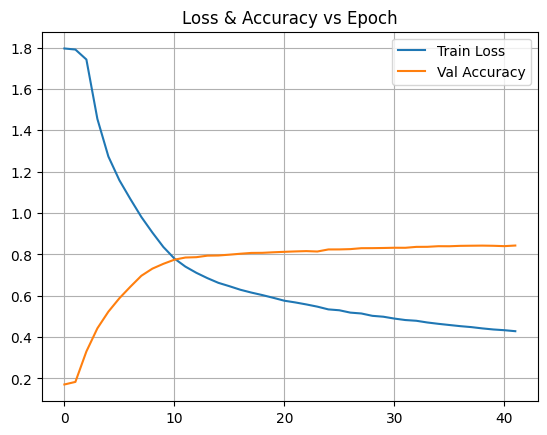

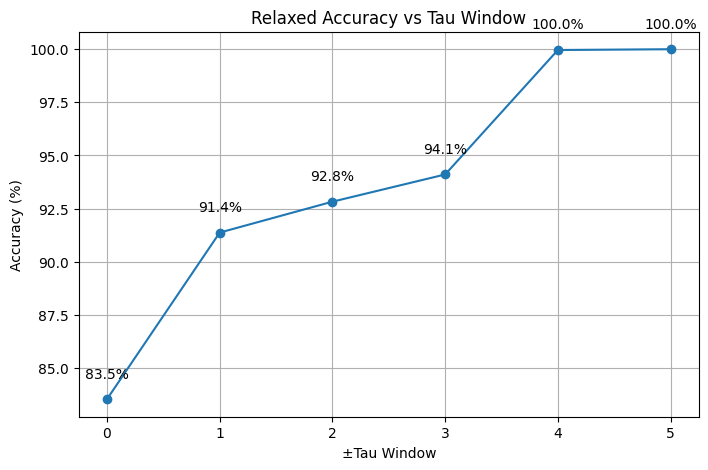

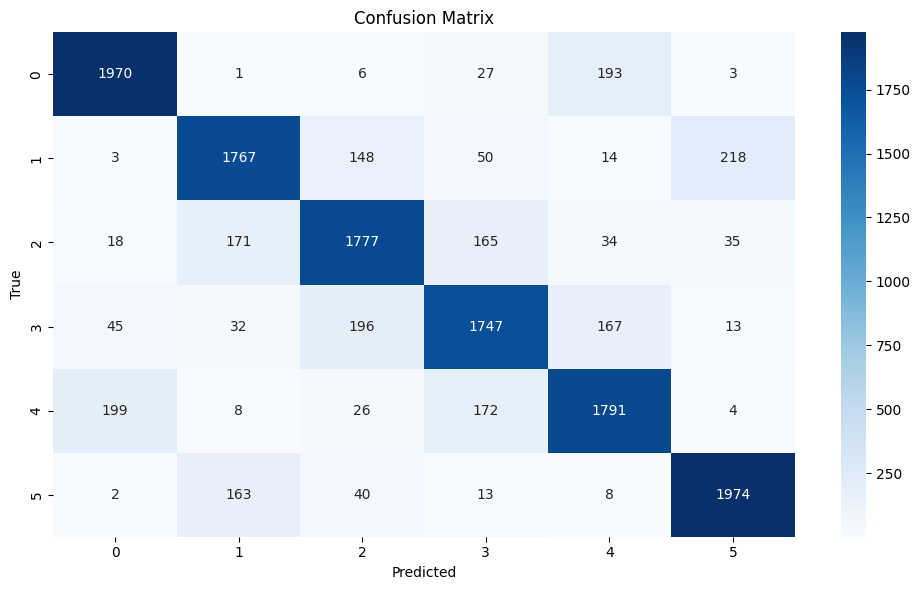

In [20]:
# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 22000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 5, p = 0.05, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 13.3, 38.5, 59.7, 80.5, 93.5, 100.0
For N'(training samples/class) = 2000     Accuracy = 16.0, 44.9, 66.8, 83.8, 94.0, 100.0
For N'(training samples/class) = 3000     Accuracy = 16.6, 44.2, 64.9, 82.1, 93.7, 100.0
For N'(training samples/class) = 4000     Accuracy = 17.5, 46.3, 66.1, 82.1, 95.4, 100.0
For N'(training samples/class) = 5000     Accuracy = 64.0, 80.0, 83.5, 86.5, 99.9, 100.0
For N'(training samples/class) = 6000     Accuracy = 71.3, 84.1, 87.7, 90.1, 100.0, 100.0
For N'(training samples/class) = 8000     Accuracy = 76.6, 87.0, 90.1, 92.6, 100.0, 100.0
For N'(training samples/class) = 10000     Accuracy = 80.4, 89.4, 91.5, 93.4, 100.0, 100.0 
For N'(training samples/class) = 12000     Accuracy = 82,2, 90.2, 92.0, 93.7, 100.0, 100.0 
For N'(training samples/class) = 15000     Accuracy = 82.6, 90.8, 92.4, 94.1, 100.0, 100.0
For N'(training samples/class) = 18000     Accuracy = 82.2, 90.6, 92.3, 93.9, 100.0, 100.0
For N'(training samples/class) = 20000     Accuracy = 83.7, 91.4, 92.8, 94.3, 100.0, 100.0
For N'(training samples/class) = 22000     Accuracy = 83.5, 91.4, 92.8, 94.1, 100.0, 100.0 
</pre>

In [ ]:
print("Predicted labels (test set):", all_preds.tolist())

## p = 0.10

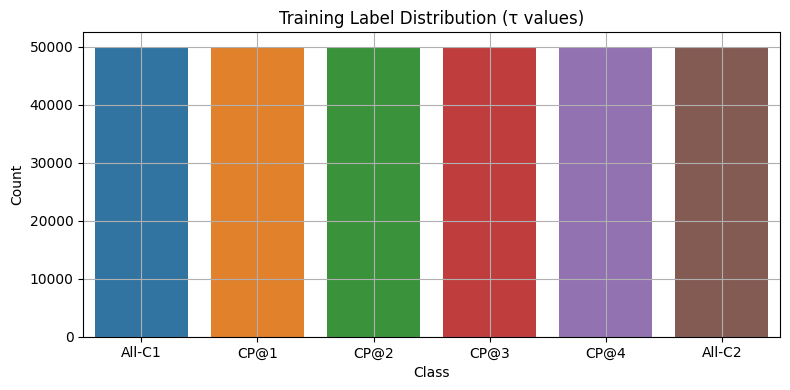

Training Epochs:   2%|▏         | 1/50 [00:28<23:17, 28.53s/it]

Epoch  1 | Train Loss: 1.7939 | Val Accuracy: 0.1711


Training Epochs:   4%|▍         | 2/50 [00:57<22:52, 28.60s/it]

Epoch  2 | Train Loss: 1.7902 | Val Accuracy: 0.2076


Training Epochs:   6%|▌         | 3/50 [01:25<22:28, 28.70s/it]

Epoch  3 | Train Loss: 1.7000 | Val Accuracy: 0.3158


Training Epochs:   8%|▊         | 4/50 [01:54<22:01, 28.73s/it]

Epoch  4 | Train Loss: 1.5308 | Val Accuracy: 0.4064


Training Epochs:  10%|█         | 5/50 [02:23<21:39, 28.88s/it]

Epoch  5 | Train Loss: 1.4163 | Val Accuracy: 0.4706


Training Epochs:  12%|█▏        | 6/50 [02:52<21:05, 28.77s/it]

Epoch  6 | Train Loss: 1.3166 | Val Accuracy: 0.5225


Training Epochs:  14%|█▍        | 7/50 [03:20<20:30, 28.61s/it]

Epoch  7 | Train Loss: 1.2420 | Val Accuracy: 0.5578


Training Epochs:  16%|█▌        | 8/50 [03:49<19:56, 28.50s/it]

Epoch  8 | Train Loss: 1.1851 | Val Accuracy: 0.5843


Training Epochs:  18%|█▊        | 9/50 [04:17<19:25, 28.42s/it]

Epoch  9 | Train Loss: 1.1385 | Val Accuracy: 0.5995


Training Epochs:  20%|██        | 10/50 [04:45<18:54, 28.36s/it]

Epoch 10 | Train Loss: 1.1013 | Val Accuracy: 0.6097


Training Epochs:  22%|██▏       | 11/50 [05:14<18:29, 28.46s/it]

Epoch 11 | Train Loss: 1.0739 | Val Accuracy: 0.6222


Training Epochs:  24%|██▍       | 12/50 [05:42<18:01, 28.46s/it]

Epoch 12 | Train Loss: 1.0486 | Val Accuracy: 0.6251


Training Epochs:  26%|██▌       | 13/50 [06:10<17:31, 28.43s/it]

Epoch 13 | Train Loss: 1.0283 | Val Accuracy: 0.6341


Training Epochs:  28%|██▊       | 14/50 [06:40<17:13, 28.71s/it]

Epoch 14 | Train Loss: 1.0106 | Val Accuracy: 0.6377


Training Epochs:  30%|███       | 15/50 [07:09<16:53, 28.96s/it]

Epoch 15 | Train Loss: 0.9948 | Val Accuracy: 0.6437


Training Epochs:  32%|███▏      | 16/50 [07:38<16:25, 29.00s/it]

Epoch 16 | Train Loss: 0.9797 | Val Accuracy: 0.6479


Training Epochs:  34%|███▍      | 17/50 [08:08<16:01, 29.13s/it]

Epoch 17 | Train Loss: 0.9664 | Val Accuracy: 0.6503


Training Epochs:  36%|███▌      | 18/50 [08:37<15:33, 29.16s/it]

Epoch 18 | Train Loss: 0.9542 | Val Accuracy: 0.6574


Training Epochs:  38%|███▊      | 19/50 [09:06<15:04, 29.19s/it]

Epoch 19 | Train Loss: 0.9425 | Val Accuracy: 0.6602


Training Epochs:  40%|████      | 20/50 [09:36<14:38, 29.29s/it]

Epoch 20 | Train Loss: 0.9308 | Val Accuracy: 0.6625


Training Epochs:  42%|████▏     | 21/50 [10:05<14:11, 29.36s/it]

Epoch 21 | Train Loss: 0.9229 | Val Accuracy: 0.6664


Training Epochs:  44%|████▍     | 22/50 [10:35<13:45, 29.47s/it]

Epoch 22 | Train Loss: 0.9125 | Val Accuracy: 0.6719


Training Epochs:  46%|████▌     | 23/50 [11:05<13:22, 29.73s/it]

Epoch 23 | Train Loss: 0.9044 | Val Accuracy: 0.6787


Training Epochs:  48%|████▊     | 24/50 [11:35<12:52, 29.69s/it]

Epoch 24 | Train Loss: 0.8976 | Val Accuracy: 0.6780


Training Epochs:  50%|█████     | 25/50 [12:05<12:21, 29.66s/it]

Epoch 25 | Train Loss: 0.8903 | Val Accuracy: 0.6784


Training Epochs:  52%|█████▏    | 26/50 [12:34<11:50, 29.59s/it]

Epoch 26 | Train Loss: 0.8834 | Val Accuracy: 0.6815


Training Epochs:  54%|█████▍    | 27/50 [13:03<11:17, 29.44s/it]

Epoch 27 | Train Loss: 0.8779 | Val Accuracy: 0.6824


Training Epochs:  56%|█████▌    | 28/50 [13:32<10:41, 29.17s/it]

Epoch 28 | Train Loss: 0.8730 | Val Accuracy: 0.6842


Training Epochs:  58%|█████▊    | 29/50 [14:01<10:12, 29.15s/it]

Epoch 29 | Train Loss: 0.8672 | Val Accuracy: 0.6895


Training Epochs:  60%|██████    | 30/50 [14:30<09:40, 29.02s/it]

Epoch 30 | Train Loss: 0.8629 | Val Accuracy: 0.6855


Training Epochs:  62%|██████▏   | 31/50 [14:58<09:10, 28.95s/it]

Epoch 31 | Train Loss: 0.8584 | Val Accuracy: 0.6912


Training Epochs:  64%|██████▍   | 32/50 [15:28<08:42, 29.02s/it]

Epoch 32 | Train Loss: 0.8543 | Val Accuracy: 0.6923


Training Epochs:  66%|██████▌   | 33/50 [15:57<08:15, 29.12s/it]

Epoch 33 | Train Loss: 0.8494 | Val Accuracy: 0.6894


Training Epochs:  68%|██████▊   | 34/50 [16:27<07:48, 29.29s/it]

Epoch 34 | Train Loss: 0.8475 | Val Accuracy: 0.6895


Training Epochs:  70%|███████   | 35/50 [16:56<07:17, 29.18s/it]

Epoch 35 | Train Loss: 0.8422 | Val Accuracy: 0.6959


Training Epochs:  72%|███████▏  | 36/50 [17:24<06:47, 29.12s/it]

Epoch 36 | Train Loss: 0.8398 | Val Accuracy: 0.6958


Training Epochs:  74%|███████▍  | 37/50 [17:54<06:18, 29.12s/it]

Epoch 37 | Train Loss: 0.8363 | Val Accuracy: 0.6965


Training Epochs:  76%|███████▌  | 38/50 [18:23<05:50, 29.21s/it]

Epoch 38 | Train Loss: 0.8334 | Val Accuracy: 0.6973


Training Epochs:  76%|███████▌  | 38/50 [18:52<05:57, 29.80s/it]

Epoch 39 | Train Loss: 0.8313 | Val Accuracy: 0.6968
Early stopping triggered.



Final Test Accuracy: 0.6996



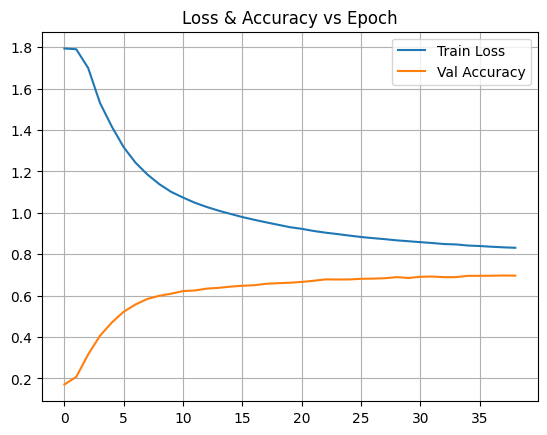

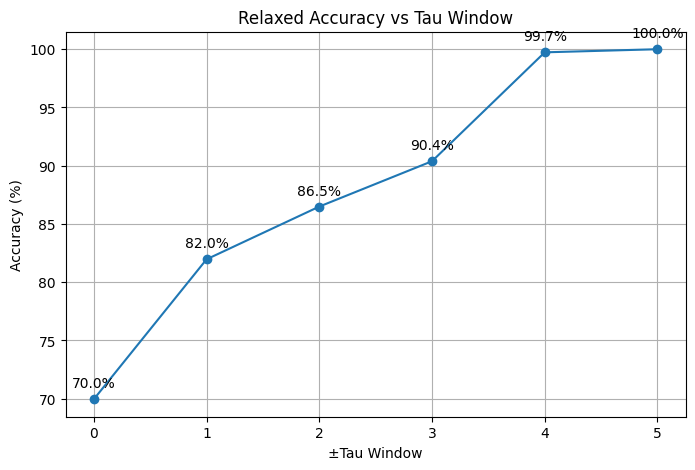

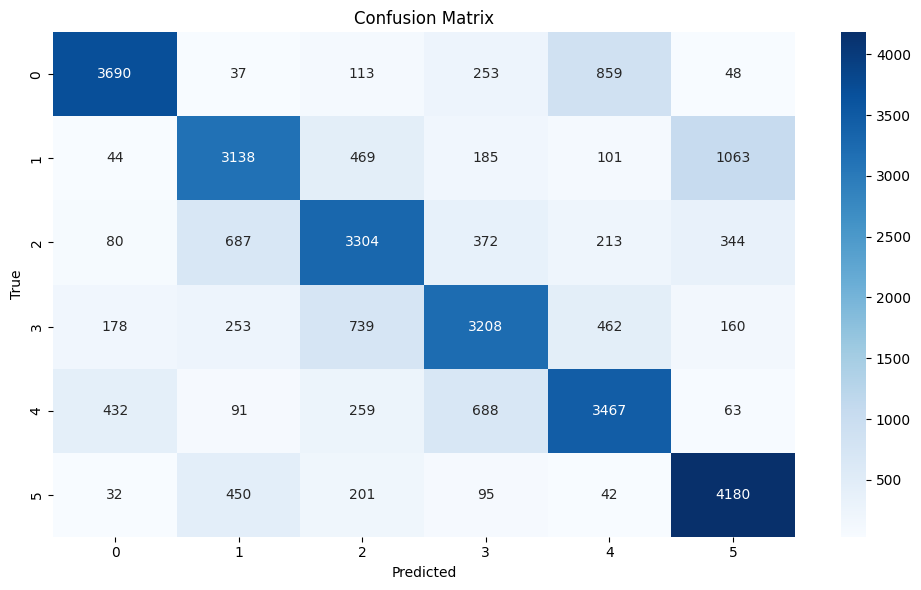

In [3]:
# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 50000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.10_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.10_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 5, p = 0.10, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 16.3, 42.7, 67.8, 85.3, 95.5, 100.0
For N'(training samples/class) = 2000     Accuracy = 16.1, 45.5, 66.2, 83.8, 94.3, 100.0
For N'(training samples/class) = 3000     Accuracy = 16.4,
For N'(training samples/class) = 4000     Accuracy = 16.5, 
For N'(training samples/class) = 5000     Accuracy = 16.9, 47.3, 63.5, 85.3, 95.7, 100.0
For N'(training samples/class) = 6000     Accuracy = 16.7, 48.5, 64.4, 83,8, 94.6, 100.0
For N'(training samples/class) = 8000     Accuracy = 16.9, 42.6, 64.4, 81.4, 93.3, 100.0
For N'(training samples/class) = 10000     Accuracy = 56.1, 73.5, 80.4, 86.6, 99.7, 100.0
For N'(training samples/class) = 12000     Accuracy = 59.1, 74.6, 81.3, 87.4, 99.6, 100.0
For N'(training samples/class) = 15000     Accuracy = 
For N'(training samples/class) = 18000     Accuracy = 62.4, 77.5, 82.8, 88.3, 99.7, 100.0 
For N'(training samples/class) = 20000     Accuracy = 
For N'(training samples/class) = 22000     Accuracy = 64.0, 78.2, 83.5, 88.5, 99.7, 100.0
For N'(training samples/class) = 24000     Accuracy = 
For N'(training samples/class) = 26000     Accuracy = 
For N'(training samples/class) = 28000     Accuracy = 65.9, 79.4, 84.2, 88.9, 99.6, 100.0
For N'(training samples/class) = 50000     Accuracy = 70.0, 82.0, 86.5, 90.4, 99.7, 100.0
</pre>

## p = 0.20

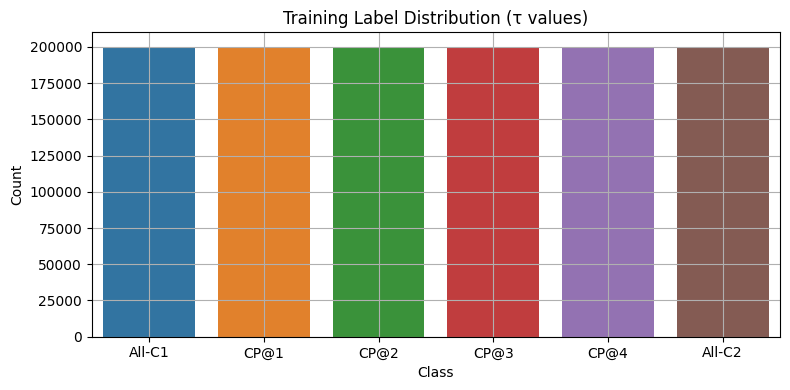

Training Epochs:   2%|▏         | 1/50 [01:55<1:34:17, 115.46s/it]

Epoch  1 | Train Loss: 1.7925 | Val Accuracy: 0.1686


Training Epochs:   4%|▍         | 2/50 [03:51<1:32:39, 115.82s/it]

Epoch  2 | Train Loss: 1.7918 | Val Accuracy: 0.1696


Training Epochs:   6%|▌         | 3/50 [05:47<1:30:49, 115.95s/it]

Epoch  3 | Train Loss: 1.7868 | Val Accuracy: 0.1961


Training Epochs:   8%|▊         | 4/50 [07:43<1:28:54, 115.96s/it]

Epoch  4 | Train Loss: 1.7780 | Val Accuracy: 0.2023


Training Epochs:  10%|█         | 5/50 [09:39<1:26:55, 115.90s/it]

Epoch  5 | Train Loss: 1.7673 | Val Accuracy: 0.2303


Training Epochs:  12%|█▏        | 6/50 [11:34<1:24:46, 115.60s/it]

Epoch  6 | Train Loss: 1.7299 | Val Accuracy: 0.2654


Training Epochs:  14%|█▍        | 7/50 [13:29<1:22:39, 115.34s/it]

Epoch  7 | Train Loss: 1.6870 | Val Accuracy: 0.2907


Training Epochs:  16%|█▌        | 8/50 [15:23<1:20:36, 115.16s/it]

Epoch  8 | Train Loss: 1.6531 | Val Accuracy: 0.3072


Training Epochs:  18%|█▊        | 9/50 [17:19<1:18:40, 115.13s/it]

Epoch  9 | Train Loss: 1.6343 | Val Accuracy: 0.3163


Training Epochs:  20%|██        | 10/50 [19:13<1:16:38, 114.95s/it]

Epoch 10 | Train Loss: 1.6207 | Val Accuracy: 0.3249


Training Epochs:  22%|██▏       | 11/50 [21:08<1:14:39, 114.87s/it]

Epoch 11 | Train Loss: 1.6096 | Val Accuracy: 0.3318


Training Epochs:  24%|██▍       | 12/50 [23:03<1:12:53, 115.10s/it]

Epoch 12 | Train Loss: 1.6004 | Val Accuracy: 0.3428


Training Epochs:  26%|██▌       | 13/50 [24:59<1:11:05, 115.27s/it]

Epoch 13 | Train Loss: 1.5934 | Val Accuracy: 0.3510


Training Epochs:  28%|██▊       | 14/50 [26:55<1:09:14, 115.39s/it]

Epoch 14 | Train Loss: 1.5881 | Val Accuracy: 0.3575


Training Epochs:  30%|███       | 15/50 [28:50<1:07:19, 115.40s/it]

Epoch 15 | Train Loss: 1.5840 | Val Accuracy: 0.3598


Training Epochs:  32%|███▏      | 16/50 [30:46<1:05:26, 115.47s/it]

Epoch 16 | Train Loss: 1.5812 | Val Accuracy: 0.3619


Training Epochs:  34%|███▍      | 17/50 [32:41<1:03:31, 115.49s/it]

Epoch 17 | Train Loss: 1.5782 | Val Accuracy: 0.3616


Training Epochs:  36%|███▌      | 18/50 [34:37<1:01:36, 115.52s/it]

Epoch 18 | Train Loss: 1.5757 | Val Accuracy: 0.3655


Training Epochs:  38%|███▊      | 19/50 [36:33<59:42, 115.57s/it]  

Epoch 19 | Train Loss: 1.5740 | Val Accuracy: 0.3654


Training Epochs:  40%|████      | 20/50 [38:28<57:48, 115.63s/it]

Epoch 20 | Train Loss: 1.5727 | Val Accuracy: 0.3668


Training Epochs:  42%|████▏     | 21/50 [40:24<55:53, 115.65s/it]

Epoch 21 | Train Loss: 1.5708 | Val Accuracy: 0.3675


Training Epochs:  44%|████▍     | 22/50 [42:20<53:58, 115.67s/it]

Epoch 22 | Train Loss: 1.5698 | Val Accuracy: 0.3688


Training Epochs:  46%|████▌     | 23/50 [44:15<52:01, 115.63s/it]

Epoch 23 | Train Loss: 1.5682 | Val Accuracy: 0.3679


Training Epochs:  48%|████▊     | 24/50 [46:11<50:07, 115.69s/it]

Epoch 24 | Train Loss: 1.5664 | Val Accuracy: 0.3689


Training Epochs:  48%|████▊     | 24/50 [48:07<52:07, 120.30s/it]

Epoch 25 | Train Loss: 1.5655 | Val Accuracy: 0.3685
Early stopping triggered.



Final Test Accuracy: 0.3688



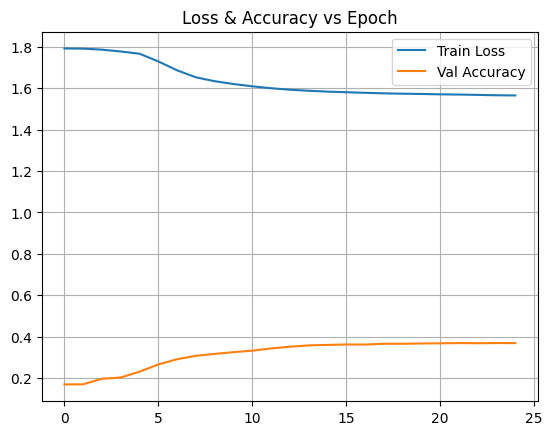

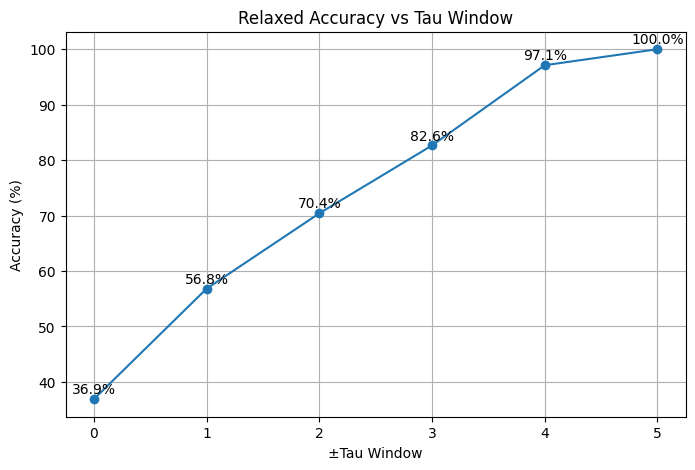

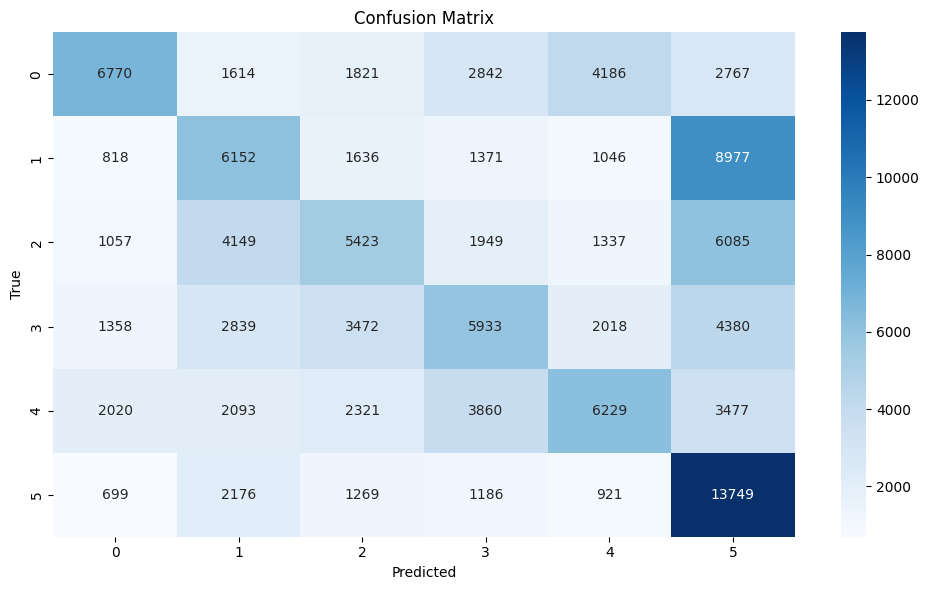

In [40]:
# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 200000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.20_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.20_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 5, p = 0.20, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 17.5, 46.0, 72.2, 87.5, 96.3, 100.0
For N'(training samples/class) = 2000     Accuracy = 
For N'(training samples/class) = 3000     Accuracy = 
For N'(training samples/class) = 4000     Accuracy = 
For N'(training samples/class) = 5000     Accuracy = 16.1, 44.8, 66.7, 83.0, 95.0, 100.0
For N'(training samples/class) = 6000     Accuracy = 
For N'(training samples/class) = 8000     Accuracy = 
For N'(training samples/class) = 10000     Accuracy = 16.4, 45.0, 66.9, 83.6, 94.5, 100.0 
For N'(training samples/class) = 11000     Accuracy = 
For N'(training samples/class) = 15000     Accuracy = 16.4, 43.6, 67.9, 85.0, 93.7, 100.0
For N'(training samples/class) = 17000     Accuracy = 
For N'(training samples/class) = 18000     Accuracy = 
For N'(training samples/class) = 20000     Accuracy = 16.9, 48.2, 70.0, 86.1, 97.6, 100.0
For N'(training samples/class) = 22000     Accuracy = 
For N'(training samples/class) = 24000     Accuracy = 
For N'(training samples/class) = 26000     Accuracy = 
For N'(training samples/class) = 28000     Accuracy = 
For N'(training samples/class) = 30000     Accuracy = 
For N'(training samples/class) = 32000     Accuracy = 
For N'(training samples/class) = 35000     Accuracy = 16.9, 48.2, 70.0, 86.1, 97.6, 100.0
For N'(training samples/class) = 50000     Accuracy = 16.9, 44.4, 64.3, 80.8, 94,6, 100.0 
For N'(training samples/class) = 100000     Accuracy = 34.9, 55.4, 69.6, 82.1, 96.9, 100.0
For N'(training samples/class) = 150000     Accuracy = 35.9, 55.8, 70.0, 82.3, 96.8, 100.0
For N'(training samples/class) = 200000     Accuracy = 36.9, 56.8, 70.4, 82.6, 97.1, 100.0
</pre>

## Summary Plots (for T = 5, CL=15) : CNN Architecture 

### All the data accumulated 